# Channel cross-section evolution


## Python setup

In [1]:
import bedrock_river as br, sympy as sy, numpy as np, matplotlib.pyplot as plt
from dill.source import getsource
sy.init_printing(pretty_print=True,wrap_line=True)
from symbols import *

In [2]:
cm = br.channel.new_model()

Initializing open channel flow hydraulics...done


## Recipe

1. Fix base width $w$, slope $\beta_0$, sinuosity $\chi=0$
2. Fix wall angle $\theta=\pi/2$ thus imposing simple initial rectangular cross-section (ignoring beveled corners)

Loop:
3. Compute flow speed $u$ and flow depth $d$
4. Compute bedload flux $q_b$
5. Compute suspended load flux profile fractions at (i) wall-base corner $q_c$ (ii) remainder above corner $q_w$
6. Optionally compute wall & corner weathering rates to modulate their erodibility
7. Compute base wear rate $\xi_b$, corner wear rate $\xi_c$ and wall wear rate $\xi_w$
8. Compute base-corner vector $\vec{\xi}_{bc}$, base-corner vector dip (from vertical) $\theta$
9. Convert into rate of change of base channel width $\dot{w}$;  secondarily compute base elevation $\dot{h}$
10. Compute wall base-corner-driven motion vector $\vec{\xi}_{wc}$ and wall rotation rate $\dot{\theta}$
11. Time step by $\Delta{t}$ the ODE system $(\dot{w}, \dot{\theta})$ of rates of change of channel base width and wall dip; secondarily evolve base elevation $\dot{h}$ 
12. Repeat

## Derivation

### Wall geometry evolution

The base-corner vector magnitude is:

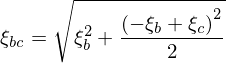

In [3]:
sy.Eq(xi_bc, sy.sqrt(xi_b**2+(xi_c-xi_b)**2/2)) 

The angle $\alpha$ between corner-wall vector, with dip $\phi$ from vertical, and the wall normal, with dip $\phi$ from horizontal, is:

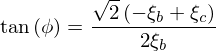

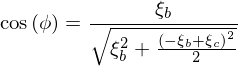

In [4]:
sy.Eq(alpha,theta-phi)
sy.Eq(sy.tan(phi),(xi_c-xi_b)/(sy.sqrt(2)*xi_b))
sy.Eq(sy.cos(phi),xi_b/sy.sqrt(xi_b**2+(xi_c-xi_b)**2/2))

The difference between the projection of $\vec{\xi}_{bc}$ onto the wall-normal direction and the wall-normal erosion rate $\xi_w$ leads to the rate of change of wall dip $\dot{\theta}(t)$:

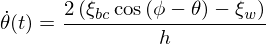

In [5]:
f_dot_theta   = sy.Function('\dot{\\theta}', real=True)(t)
sy.Eq(f_dot_theta, (xi_bc*sy.cos(theta-phi)-xi_w)*(2/h))

Since we track $\xi_{bc}(t), \xi_{w}(t), \theta(t)$ and since wall height $h(t)$ will be a simple function of (equal to?) flow depth $d(t)$, we have enought to compute $\dot{\theta}(t)$ at each time step.

At steady-state, $\dot\theta=0$, thus $\xi_w=\xi_{bc}\cos(\phi-\theta_{ss})$, and thus:

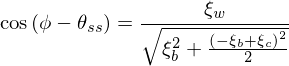

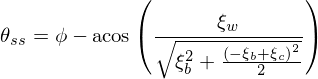

In [6]:
sy.Eq(sy.cos(theta_ss-phi),xi_w/sy.sqrt(xi_b**2+(xi_c-xi_b)**2/2))
sy.Eq(theta_ss,phi-sy.acos(xi_w/sy.sqrt(xi_b**2+(xi_c-xi_b)**2/2)))

### Open channel flow: cross-sectional area and wetted perimeter $p$

Flow cross-sectional area $A$:

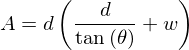

In [7]:
cm.A_eqn_geom()

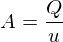

In [8]:
cm.A_eqn_dyn()

Wetted perimeter $p$:

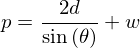

In [9]:
cm.p_eqn()

    def R_eqn(self):
        return sy.Eq(R, self.A_eqn_dyn().rhs/self.p_eqn().rhs).simplify()



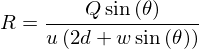

In [10]:
print(getsource(cm.R_eqn))
cm.R_eqn()

### Open channel flow:  boundary shear stress $\tau$ and shear velocity $u^*$

Mean boundary shear stress $\tau$, averaged along wetted perimeter $p$:

    def tau_eqn_raw(self):
        return sy.Eq(tau,(rho*g*A*sy.sin(beta)/p).subs(A,self.A_eqn_dyn().rhs))



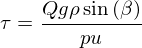

In [11]:
print(getsource(cm.tau_eqn_raw))
cm.tau_eqn_raw()

    def tau_eqn_geom(self):
        return self.tau_eqn_raw().subs(p,self.p_eqn().rhs).simplify()



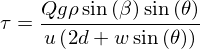

In [12]:
print(getsource(cm.tau_eqn_geom))
cm.tau_eqn_geom()

Mean shear stress at a rough boundary:

In [13]:
cm.tau_eqn_friction()
# cm.tau_eqn_manning_friction()

Dimensionless friction factor $f$ and Chézy roughness coefficient $C$ (for which $C_Z = \dfrac{1}{\sqrt{g}C}$):

In [14]:
cm.friction_eqn_chezy()

Friction factor $f$ and Manning's $n$:

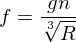

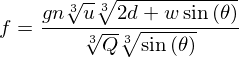

In [15]:
cm.friction_eqn_manning_raw()
cm.friction_eqn_manning()

Combining for each roughness model, we have mean boundary shear stress for Chézy versus Manning:

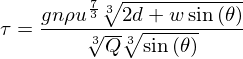

In [16]:
cm.tau_eqn_friction().subs(f,cm.friction_eqn_chezy().rhs)
cm.tau_eqn_friction().subs(f,cm.friction_eqn_manning().rhs)

The choice here is for:

In [17]:
cm.tau_eqn_dyn()

Shear or friction "velocity" $u^*$:

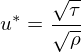

In [18]:
cm.u_star_eqn_raw()

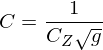

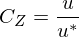

In [19]:
tmp = sy.Eq(u_star**2,(cm.u_star_eqn_raw().rhs**2).subs(tau,
    cm.tau_eqn_friction().subs(f,cm.friction_eqn_chezy().rhs).rhs))
tmp
sy.Eq(C,1/(sy.sqrt(g)*Cz))
sy.Eq(Cz,sy.solve(sy.Eq(C,sy.solve(tmp,C)[0]).subs(C,1/(sy.sqrt(g)*Cz)),Cz)[0])

In [20]:
cm.u_star_eqn().simplify()

### Open channel flow: speed $u$

Mean flow speed $u$ equations assuming an isoceles trapezoidal cross-section:

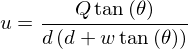

In [21]:
cm.u_eqn_geom()

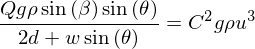

In [24]:
tmp = sy.Eq(cm.tau_eqn_geom().rhs,cm.tau_eqn_dyn().rhs)
u_eqn = sy.Eq(tmp.lhs*u,tmp.rhs*u)
u_eqn

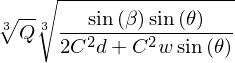

In [27]:
sy.solve(u_eqn,u)[0]

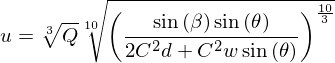

In [25]:
tmp = sy.Eq(u,
      (sy.solve(u_eqn.subs(u**sy.Rational(10,3),t),t)[0].subs(t,u**sy.Rational(10,3))**3)
           **sy.Rational(1,10))
tmp.subs(sy.Abs(sy.sin(theta)),sy.sin(theta))\
   .subs(sy.Abs(2*d+w*sy.sin(theta)),2*d+w*sy.sin(theta))

In [ ]:
print(getsource(cm.ucubed_eqn_dyn))

In [ ]:
cm.ucubed_eqn_dyn()

### Open channel flow: depth $d$

Flow depth $d$ (above centerline) equations assuming an isoceles trapezoidal cross-section:

In [ ]:
cm.d_eqn_dyn()

In [ ]:
cm.d_eqn_geom()

### Open channel flow: explicit solutions for depth $d$ and flow $u$

Combining to yield polynomials for $u$ and $d$:

In [ ]:
cm.d_eqn_poly()
_.subs({C:1,Q:1,beta:sy.pi/4,theta:sy.pi/4,w:1}).simplify()

In [ ]:
cm.u_eqn_poly()
_.subs({C:1,Q:1,beta:sy.pi/4,theta:sy.pi/4,w:1}).simplify()

By finding the positive real roots of these equations, we can obtain $d$ and then $u$ from wall tilt $\theta$, base width $w$ and channel base slope $\beta$, together with $C$ and $Q$. We can then obtain values for boundary shear stress $\tau$ and shear velocity $u^*$.

### Bedload sediment flux $q_b$

### Suspended sediment flux fractions on wall $q_w$ and corner $q_c$

In [ ]:
# varphi = sy.symbols('varphi',  positive=True ) 
# f_varphi = sy.Function('varphi', positive=True)(Z)
# q_ss  = sy.symbols('q_ss',  positive=True ) 
# f_q_ss = sy.Function('q_ss', positive=True)(Z)
# q_w, q_c, q_b  = sy.symbols('q_w, q_c, q_b',  positive=True ) 


In [ ]:
varphi_eqn = sy.Eq(f_varphi, sy.log(Z/k)*((1-Z)/Z)**nu / ((1-Z_0)/Z_0)**nu)
varphi_eqn
varphi_lambda = sy.lambdify((Z,nu,k,Z_0),varphi_eqn.rhs,'sympy')

In [ ]:
# sy.integrate(varphi_eqn.rhs.subs(nu,sy.Rational(3,2)),(Z,Z_0,x))

In [ ]:
# sy.integrate(varphi_eqn.rhs.subs(nu,nu+1),(Z,Z_0,Z_0+x))

In [ ]:
# varphi_eqn2 = sy.Eq(f_varphi, sy.log(Z/k)*((1-Z)/Z)**nu)
# varphi_eqn2.rhs.subs(nu,nu+1).subs(Z,Z+Z_0)
# sy.integrate( varphi_eqn2.rhs.subs(nu,nu+1).subs(Z,Z+Z_0) ,Z)

In [ ]:
# ((Z_0/(1-Z_0))**nu)*(nu*sy.pi/sy.sin(nu*sy.pi))*(
#     -sy.log(Z_0)+sy.digamma(1-nu)+sy.digamma(2)
#     +Z_0
# )

In [ ]:
# sy.simplify(qss_integral.rhs.subs(nu,2))

In [ ]:
nZ = 10
dZ = 1/nZ
k_x = 0.1/30
Z_0x = 0.01
z_0x = 0.01
nu_x = 0.03/(0.4*0.2)
# nu_x = 0.06/(0.4*0.2)
varphi_lambda(Z_0x,nu_x,k_x,Z_0x)

In [ ]:
qss_integral = \
    sy.Eq(f_q_ss,
            1/(nu-1) * Z**(1-nu)*(
                       nu*sy.hyper([1-nu,1-nu,1-nu],[2-nu,2-nu],Z)/(1-nu)
                    - sy.hyper([1-nu,-nu],[2-nu],Z)*(sy.log(Z/k)-1)
            )/ ((1-Z_0)/Z_0)**nu)
qss_integral
qss_lambda = sy.lambdify((Z,nu,k,Z_0),qss_integral.rhs,'sympy')

In [ ]:
delta_Z_x = 0.0001
Z_x = 0.1
sy.N( 
   qss_integral.rhs.subs({Z:Z_x+delta_Z_x/2,nu:nu_x,k:k_x,Z_0:Z_0x})
  -qss_integral.rhs.subs({Z:Z_x-delta_Z_x/2,nu:nu_x,k:k_x,Z_0:Z_0x})
   )/delta_Z_x
np.float( (qss_lambda(Z_x+delta_Z_x/2,nu_x,k_x,Z_0x)
          -qss_lambda(Z_x-delta_Z_x/2,nu_x,k_x,Z_0x))/delta_Z_x )

In [ ]:
def qss_portions_dimless(Z,nu,k,Z_0):
    qss_upper = sy.N(qss_lambda(1,nu,k,Z_0))
    qss_Z     = sy.N(qss_lambda(Z,nu,k,Z_0))
    qss_lower = sy.N(qss_lambda(Z_0,nu,k,Z_0))
    return np.float((qss_Z-qss_lower)/(Z-Z_0)), np.float((qss_upper-qss_lower)/(1-(Z-Z_0)))
def qss_portions(d,z,nu,k,z_0):
    return qss_portions_dimless(z/d,nu,k,z_0/d)

In [ ]:
d_x = 1
qss_portions_dimless(Z_x,nu_x,k_x,Z_0x)
qss_portions(d_x,Z_x*d_x,nu_x,k_x,Z_0x*d_x)

In [ ]:
q_cx, q_wx = qss_portions(d_x,Z_x*d_x,nu_x,k_x,Z_0x*d_x)
sy.Eq(q_w, q_wx)
sy.Eq(q_c, q_cx)

## Numerical exploration

### Parameters

In [ ]:
cm.set_params(  {chi:0} )
cm.set_params(  {theta:cm.pi/4, Omega_r:10} )
cm.set_params(  {epsilon_r:0.1} )
cm.set_params(  {u_i:5,d_i:30} )
cm.get_params()

### Channel base width and wall tilt evolution: $\{\dot{w},\dot\theta\}(t)$

In [ ]:
cm.set_params(  {Q:250,mu:0.2,eta:2} )
cm.get_params()
w_range = (0.1,300)
import numpy as np
(ode_integrations_list, t_w_chi_beta0_vecs_list, 
 w_chi_beta0_interp_as_t_list, t_w_chi_beta0_resampled_vecs_list) \
  = cm.ode_integrate_w_chi_beta0(t_span=[0.0,1500],
                                 initial_state=np.array([50,0.05,0.001]))

In [ ]:
t_w_chi_beta0_resampled_vecs_list.round(4)
np.mean(t_w_chi_beta0_resampled_vecs_list[:,3])
cm.get_params({beta_0:None, Q:None})

In [ ]:
cm.reset_params()
cm.set_params(  {Q:3000,mu:1,eta:2} )
cm.get_params()
w_range = (0.1,300)
import numpy as np
(ode_integrations_list, t_w_chi_beta0_vecs_list, 
 w_chi_beta0_interp_as_t_list, t_w_chi_beta0_resampled_vecs_list) \
  = cm.ode_integrate_w_chi_beta0(t_span=[0.0,1500],
                                 initial_state=np.array([50,0.05,0.001]))

In [ ]:
t_w_chi_beta0_resampled_vecs_list.round(4)
np.mean(t_w_chi_beta0_resampled_vecs_list[:,3])
cm.get_params({beta_0:5, Q:None})
cm.get_params()

In [ ]:
plt.plot(t_w_chi_beta0_resampled_vecs_list[:,0],
         t_w_chi_beta0_resampled_vecs_list[:,3]);